# Imports

In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotnine as gg
import statsmodels.formula.api as smf
from Functions import *
gg.theme_set(gg.theme_classic)
default_figure_size = (6.4, 4.8)

In [2]:
make_firstdatextra = False
data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34'
plot_dir = data_dir + 'figures'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Get data

In [3]:
# rule_data = pd.read_csv(os.path.join(data_dir, 'rule_data.csv'), index_col=0)
# rule_data.loc[rule_data.phase == 'high'][:30]

In [4]:
all_data = pd.read_csv(os.path.join(data_dir, 'all_data.csv'), index_col=0)
all_data['subtrial'] = all_data['subtrial'].astype(int)
all_data

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (66,67) have mixed types.Specify dtype option on import or set low_memory=False.


,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,count_star3,star_rule,star0_inplace,star1_inplace,star2_inplace,star3_inplace,sex,age_years,age_months,chance_performer
0,797.865,0.0,85.0,learning,297.0,2422963.0,0.0-77.0-0.0,high,0.0,0.0,...,0,"[2, 3]",False,False,False,False,Female,21.0,6.0,False
1,654.720,0.0,73.0,learning,298.0,2423619.0,0.0-77.0-1.0,high,0.0,0.0,...,0,"[2, 3]",False,False,False,False,Female,21.0,6.0,False
2,1317.900,0.0,79.0,learning,299.0,2424938.0,0.0-77.0-2.0,high,0.0,0.0,...,0,"[2, 3]",False,False,False,False,Female,21.0,6.0,False
3,276.305,0.0,80.0,learning,300.0,2425216.0,0.0-77.0-3.0,high,0.0,0.0,...,0,"[2, 3]",False,False,False,False,Female,21.0,6.0,False
4,823.310,0.0,85.0,learning,302.0,2426546.0,0.0-78.0-0.0,high,0.0,1.0,...,0,"[2, 3]",False,False,False,False,Female,21.0,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290971,NaN,NaN,NaN,transfer,NaN,NaN,NaN,low,7.0,23.0,...,0,"[2, 1]",True,True,True,True,Male,18.0,10.0,True
290972,884.860,0.0,79.0,transfer,2790.0,1240253.0,0.0-595.0-0.0,low,7.0,24.0,...,0,"[2, 1]",True,True,True,True,Male,18.0,10.0,True
290973,203.660,0.0,80.0,transfer,2791.0,1240463.0,0.0-595.0-1.0,low,7.0,24.0,...,0,"[2, 1]",True,True,True,True,Male,18.0,10.0,True
290974,262.600,0.0,73.0,transfer,2792.0,1240731.0,0.0-595.0-2.0,low,7.0,24.0,...,0,"[2, 1]",True,True,True,True,Male,18.0,10.0,True


# Results

## Prepare data

In [5]:
# Get the trial in which an item was first discovered, for each block, each item, each participant
id_cols = ['sid', 'trial_type', 'phase', 'block', 'middle_item_both', 'subtrial']
first_dat = all_data.groupby(id_cols).aggregate('min').reset_index()[id_cols + ['trial']]
first_dat = first_dat.loc[first_dat['middle_item_both'] < 8]  # Only keep 4 non-items
first_dat['middle_item_both'] = first_dat['middle_item_both'].astype(int)
first_dat = first_dat.reset_index(drop=True)
first_dat

,sid,trial_type,phase,block,middle_item_both,subtrial,trial
0,13885,learning,high,0.0,0,1,0.0
1,13885,learning,high,0.0,0,3,13.0
2,13885,learning,high,0.0,1,1,14.0
3,13885,learning,high,0.0,1,3,5.0
4,13885,learning,high,0.0,2,1,23.0
...,...,...,...,...,...,...,...
18970,39925,transfer,low,7.0,2,1,16.0
18971,39925,transfer,low,7.0,3,1,23.0
18972,39925,transfer,low,7.0,4,3,24.0
18973,39925,transfer,low,7.0,6,3,1.0


In [6]:
def make_first_dat_extra(first_dat, trial_shifts=range(-5, 10)):
    
    """
    Select 5 trials before and 10 trials after the first discovery of an item and put them in a dataframe.
    """

    first_dat_extra = pd.DataFrame()

    for row_i in range(first_dat.shape[0]):

        if (row_i % 50) == 1:
            print('{} of {} rows ({}%)                       '.format(
                row_i+1, first_dat.shape[0], 100 * np.round((row_i+1) / first_dat.shape[0], 3)), end='\r')

        for trial_shift in trial_shifts:
            row = first_dat.loc[row_i, ['sid', 'trial_type', 'phase', 'block', 'trial', 'subtrial', 'middle_item_both']]
            row['trial'] += trial_shift
            row['trial_reltofirst'] = trial_shift
            first_dat_extra = first_dat_extra.append(row)
            
    first_dat_extra = first_dat_extra.rename(columns={'middle_item_both': 'middle_item_both_sequence', 'subtrial': 'subtrial_sequence'})
    first_dat_extra = first_dat_extra.loc[first_dat_extra['trial'] >= 0]
    first_dat_extra['trial_reltofirst'] = first_dat_extra['trial_reltofirst'].astype(int)
    first_dat_extra = first_dat_extra.reset_index(drop=True)
            
    return first_dat_extra

In [7]:
if make_firstdatextra:
    
    first_dat_extra = make_first_dat_extra(first_dat, trial_shifts=range(-5, 10))
    first_dat_extra.to_csv(os.path.join(data_dir, 'first_dat_extra.csv'), index=False)
else:

    first_dat_extra = pd.read_csv(os.path.join(data_dir, 'first_dat_extra.csv'))

In [8]:
first_dat_extra.loc[
    (first_dat_extra['trial_reltofirst'] == 0) & (first_dat_extra['middle_item_both_sequence'] > 4)
]

,block,middle_item_both_sequence,phase,sid,subtrial_sequence,trial,trial_reltofirst,trial_type
115,0.0,5.0,high,13885.0,1.0,3.0,0,learning
126,0.0,5.0,high,13885.0,3.0,1.0,0,learning
138,0.0,6.0,high,13885.0,1.0,2.0,0,learning
153,0.0,7.0,high,13885.0,3.0,11.0,0,learning
184,1.0,5.0,high,13885.0,1.0,1.0,0,learning
...,...,...,...,...,...,...,...,...
250769,6.0,6.0,low,39925.0,1.0,1.0,0,transfer
250779,6.0,6.0,low,39925.0,3.0,0.0,0,transfer
250794,6.0,7.0,low,39925.0,3.0,9.0,0,transfer
250896,7.0,6.0,low,39925.0,3.0,1.0,0,transfer


In [9]:
first_dat_extra.loc[first_dat_extra['middle_item_both_sequence'] > 4][:30]

,block,middle_item_both_sequence,phase,sid,subtrial_sequence,trial,trial_reltofirst,trial_type
112,0.0,5.0,high,13885.0,1.0,0.0,-3,learning
113,0.0,5.0,high,13885.0,1.0,1.0,-2,learning
114,0.0,5.0,high,13885.0,1.0,2.0,-1,learning
115,0.0,5.0,high,13885.0,1.0,3.0,0,learning
116,0.0,5.0,high,13885.0,1.0,4.0,1,learning
117,0.0,5.0,high,13885.0,1.0,5.0,2,learning
118,0.0,5.0,high,13885.0,1.0,6.0,3,learning
119,0.0,5.0,high,13885.0,1.0,7.0,4,learning
120,0.0,5.0,high,13885.0,1.0,8.0,5,learning
121,0.0,5.0,high,13885.0,1.0,9.0,6,learning


In [10]:
# Get info on actions, rts, etc. on these selected trials and add them to the dataframe
f_dat = pd.merge(first_dat_extra, all_data, how='left')

# `sequence_item_bool` indicates whether the current item is the one that this sequence is about, i.e., 
# the one that occurs for the first time at `trial_reltofirst` == 0 and because of which we collected all
# the trials before and after.
f_dat['sequence_item_bool'] = f_dat['middle_item_both_sequence'] == f_dat['middle_item_both']
f_dat['sequence_item_bool'] = f_dat['sequence_item_bool'].astype(int)

# exists indicates whether a 2-key sequence "exists" (leads to an item on the screen) or not (any made-up sequence
# with no consequence for the game).
f_dat['valid'] = f_dat['middle_item_both'].apply(lambda x : 'valid' if x < 4 else 'invalid')

# Check it out
f_dat[
    ['sid', 'phase', 'trial_type', 'block', 'trial', 'subtrial', 'action_id', 'middle_item_both_sequence', 'middle_item_both', 'subtrial_sequence', 'trial_reltofirst', ]
][40:70]

,sid,phase,trial_type,block,trial,subtrial,action_id,middle_item_both_sequence,middle_item_both,subtrial_sequence,trial_reltofirst
40,13885.0,high,learning,0.0,8.0,0.0,0.0,0.0,NaN,3.0,-5
41,13885.0,high,learning,0.0,8.0,1.0,1.0,0.0,0.0,3.0,-5
42,13885.0,high,learning,0.0,8.0,2.0,1.0,0.0,NaN,3.0,-5
43,13885.0,high,learning,0.0,8.0,3.0,3.0,0.0,11.0,3.0,-5
44,13885.0,high,learning,0.0,9.0,0.0,0.0,0.0,NaN,3.0,-4
45,13885.0,high,learning,0.0,9.0,1.0,1.0,0.0,0.0,3.0,-4
46,13885.0,high,learning,0.0,9.0,2.0,2.0,0.0,NaN,3.0,-4
47,13885.0,high,learning,0.0,9.0,3.0,3.0,0.0,1.0,3.0,-4
48,13885.0,high,learning,0.0,10.0,0.0,0.0,0.0,NaN,3.0,-3
49,13885.0,high,learning,0.0,10.0,1.0,1.0,0.0,0.0,3.0,-3


## Choices around item discovery

In [11]:
sub_dat = f_dat.loc[
    (f_dat['sid'].isin(list(set(f_dat['sid']))[:5])) &  # Display 10 participants to keep figure reasonable
    (f_dat['block'] == 0) &  # Display only blocks 0 and 1
    (f_dat['middle_item_both_sequence'] < 4)
     ]
sub_dat[['sid', 'phase', 'trial_type', 'block', 'trial', 'subtrial', 'action_id', 'middle_item_both_sequence', 'middle_item_both', 'subtrial_sequence', 'trial_reltofirst', 'valid']]

,sid,phase,trial_type,block,trial,subtrial,action_id,middle_item_both_sequence,middle_item_both,subtrial_sequence,trial_reltofirst,valid
87735,24964.0,high,learning,0.0,0.0,0.0,2.0,0.0,NaN,1.0,-2,invalid
87736,24964.0,high,learning,0.0,0.0,1.0,0.0,0.0,4.0,1.0,-2,invalid
87737,24964.0,high,learning,0.0,0.0,2.0,1.0,0.0,NaN,1.0,-2,invalid
87738,24964.0,high,learning,0.0,0.0,3.0,3.0,0.0,11.0,1.0,-2,invalid
87739,24964.0,high,learning,0.0,1.0,0.0,2.0,0.0,NaN,1.0,-1,invalid
...,...,...,...,...,...,...,...,...,...,...,...,...
891464,39304.0,low,transfer,0.0,12.0,3.0,1.0,3.0,7.0,3.0,8,invalid
891465,39304.0,low,transfer,0.0,13.0,0.0,3.0,3.0,NaN,3.0,9,invalid
891466,39304.0,low,transfer,0.0,13.0,1.0,0.0,3.0,NaN,3.0,9,invalid
891467,39304.0,low,transfer,0.0,13.0,2.0,1.0,3.0,NaN,3.0,9,invalid


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 161 rows containing missing values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:261: PlotnineWarning: geom_point legend : Removed 1 rows containing missing values.


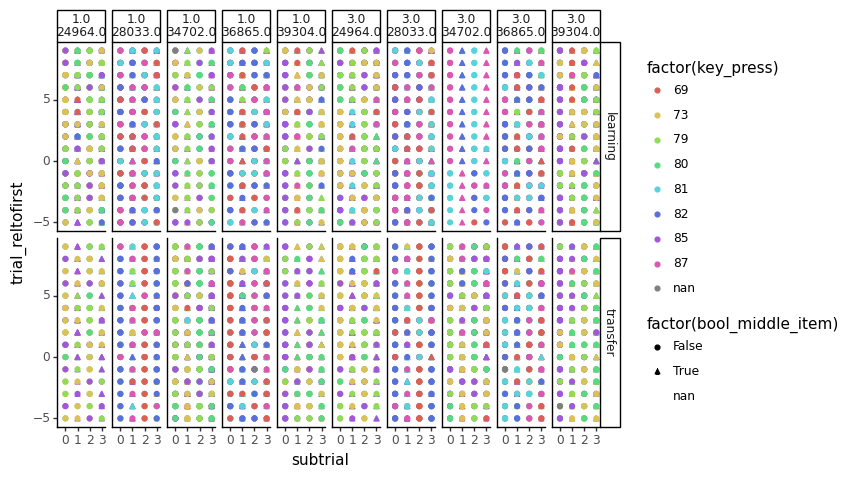

<ggplot: (168747940265)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 7 x 5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34figures\104_RawKeyPressesAroundItemDiscovery.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 161 rows containing missing values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:261: PlotnineWarning: geom_point legend : Removed 1 rows containing missing values.


In [12]:
gg.options.figure_size = (7, 5)
g = (gg.ggplot(sub_dat, gg.aes('subtrial', 'trial_reltofirst', color='factor(key_press)', shape='factor(bool_middle_item)'))
     + gg.geom_point()
     + gg.coord_cartesian(xlim=(-0.5, 3.1))
     + gg.facet_grid('trial_type ~ subtrial_sequence + sid', scales='free_x')#, labeller='label_both')
    )
print(g)
g.save(os.path.join(plot_dir, '104_RawKeyPressesAroundItemDiscovery.png'))
gg.options.figure_size = default_figure_size

## RTs around item discovery

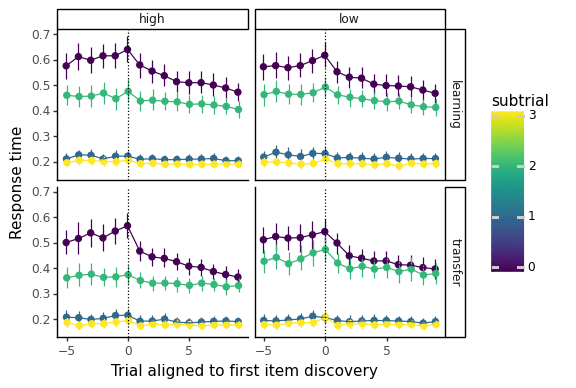

<ggplot: (168726965242)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34figures\104_subtrialRtsOverTrialreltofirst.png


In [13]:
subj_dat = f_dat.loc[
    (f_dat['subtrial_sequence'] == 1)  # new item discovered on subtrial 1 (not 3)
].groupby(
    ['sid', 'phase', 'trial_type', 'trial_reltofirst', 'subtrial']).aggregate('mean').reset_index()

# Strong decrease in subtrial0 and subtrial1 RT! => Because we're learning this item :)
gg.options.figure_size = (5, 4)
g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'rt/1000', color='subtrial', group='subtrial'))
     + gg.stat_summary(position=gg.position_dodge(width=0.1))
     + gg.stat_summary(geom='line', position=gg.position_dodge(width=0.1))
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.labs(x='Trial aligned to first item discovery', y='Response time')
     + gg.facet_grid('trial_type ~ phase')
    )
print(g)
g.save(os.path.join(plot_dir, '104_subtrialRtsOverTrialreltofirst.png'))

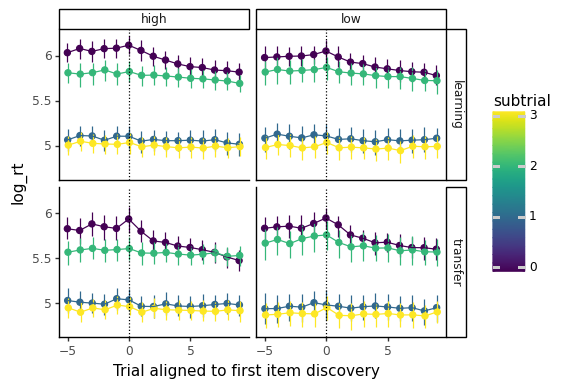

<ggplot: (168726965242)>

In [14]:
g += gg.aes(y='log_rt')
g

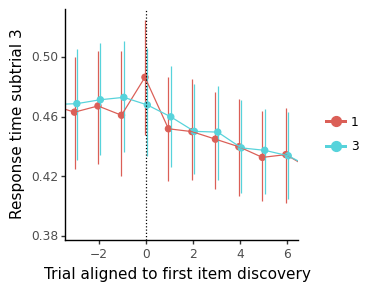

<ggplot: (168729151127)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34figures\104_subtrial2RtsOverTrialreltofirst.png


In [15]:
subj_dat = f_dat.loc[
    (f_dat['subtrial_sequence'].isin([1, 3])) & (f_dat['trial_type'] == 'learning') & (f_dat['subtrial'] == 2)
].groupby(
    ['sid', 'trial_reltofirst', 'subtrial', 'subtrial_sequence']).aggregate('mean').reset_index()

gg.options.figure_size = (3, 3)
g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'rt/1000', color='factor(subtrial_sequence)', group='factor(subtrial_sequence)'))
     + gg.stat_summary(position=gg.position_dodge(width=0.2))
     + gg.stat_summary(geom='line', position=gg.position_dodge(width=0.2))
     + gg.coord_cartesian(xlim=(-3, 6))
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.labs(x='Trial aligned to first item discovery', y='Response time subtrial 3', color='')
    )
print(g)
g.save(os.path.join(plot_dir, '104_subtrial2RtsOverTrialreltofirst.png'))

In [16]:
cols = ['sid','trial_reltofirst', 'subtrial', 'subtrial_sequence', 'block', 'action_id', 'rt', 'acc']

In [17]:
subj_dat[:30][cols]

,sid,trial_reltofirst,subtrial,subtrial_sequence,block,action_id,rt,acc
0,13885.0,-5,2.0,1.0,4.566667,1.566667,576.702667,0.133333
1,13885.0,-5,2.0,3.0,4.631579,1.447368,568.611184,0.078947
2,13885.0,-4,2.0,1.0,4.794118,1.294118,510.124706,0.117647
3,13885.0,-4,2.0,3.0,4.681818,1.636364,488.690795,0.068182
4,13885.0,-3,2.0,1.0,4.825000,1.500000,535.881125,0.100000
5,13885.0,-3,2.0,3.0,4.839286,1.535714,531.739018,0.053571
6,13885.0,-2,2.0,1.0,4.772727,1.636364,559.002045,0.113636
7,13885.0,-2,2.0,3.0,5.000000,1.432836,536.071791,0.059701
8,13885.0,-1,2.0,1.0,4.839286,1.339286,489.145268,0.089286
9,13885.0,-1,2.0,3.0,5.000000,1.604938,526.685000,0.049383


In [18]:
sub_dat = subj_dat.loc[subj_dat['subtrial_sequence'] == 1]
t0 = sub_dat.loc[sub_dat['trial_reltofirst'] == 0]
tm1 = sub_dat.loc[sub_dat['trial_reltofirst'] == -1]
tp1 = sub_dat.loc[sub_dat['trial_reltofirst'] == 1]
t0[:30][cols]

,sid,trial_reltofirst,subtrial,subtrial_sequence,block,action_id,rt,acc
10,13885.0,0,2.0,1.0,5.027027,1.310811,534.063176,0.094595
40,14239.0,0,2.0,1.0,5.306306,1.423423,576.477477,0.018018
70,15670.0,0,2.0,1.0,4.850575,1.402299,683.066782,0.103448
100,16849.0,0,2.0,1.0,5.593750,1.677083,528.482760,0.125000
130,24817.0,0,2.0,1.0,4.965217,1.591304,560.910391,0.078261
160,24964.0,0,2.0,1.0,5.640000,1.688000,356.032000,0.024000
190,24979.0,0,2.0,1.0,4.948718,1.641026,527.097821,0.166667
220,26179.0,0,2.0,1.0,5.336207,1.508621,573.103190,0.060345
250,26230.0,0,2.0,1.0,5.231481,1.175926,658.333333,0.092593
280,26641.0,0,2.0,1.0,5.333333,1.609195,321.754368,0.137931


In [19]:
id_cols = ['sid', 'subtrial', 'subtrial_sequence']
int_cols = ['rt']
t_dat = pd.merge(
    pd.merge(t0[id_cols + int_cols], tp1[id_cols + int_cols], on=id_cols, suffixes=['_0', '_p1']),
    tm1[id_cols + int_cols], on=id_cols
).rename(columns={'rt': 'rt_m1'})
t_dat

,sid,subtrial,subtrial_sequence,rt_0,rt_p1,rt_m1
0,13885.0,2.0,1.0,534.063176,510.455137,489.145268
1,14239.0,2.0,1.0,576.477477,536.678899,576.043478
2,15670.0,2.0,1.0,683.066782,619.383294,705.737424
3,16849.0,2.0,1.0,528.482760,492.717473,590.431875
4,24817.0,2.0,1.0,560.910391,529.988870,517.980670
5,24964.0,2.0,1.0,356.032000,376.040323,415.574074
6,24979.0,2.0,1.0,527.097821,500.183013,563.325862
7,26179.0,2.0,1.0,573.103190,540.846652,569.936615
8,26230.0,2.0,1.0,658.333333,584.457944,607.933333
9,26641.0,2.0,1.0,321.754368,318.094294,285.963478


In [21]:
# Comparing RT within participants
import scipy
(scipy.stats.ttest_rel(t_dat['rt_0'], t_dat['rt_p1']),
 scipy.stats.ttest_rel(t_dat['rt_0'], t_dat['rt_m1']),
 scipy.stats.ttest_rel(t_dat['rt_m1'], t_dat['rt_p1']))

(Ttest_relResult(statistic=6.9328862501160575, pvalue=4.85868830924872e-09),
 Ttest_relResult(statistic=4.064255953284124, pvalue=0.0001545310632002445),
 Ttest_relResult(statistic=1.4547968756432452, pvalue=0.1514092666397949))

In [ ]:
sub_dat_st2 = f_dat.loc[
    f_dat['subtrial_sequence'].isin([1]) & (f_dat['trial_reltofirst'].isin([-1, 0])) & (f_dat['middle_item_both_sequence'] < 4)
]

subj_dat = sub_dat_st2.groupby(['sid', 'phase', 'trial_type', 'subtrial', 'subtrial_sequence', 'trial_reltofirst', 'middle_item_both_sequence']).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('factor(trial_reltofirst)', 'log_rt', color='phase', group='phase'))
     + gg.stat_summary(position=gg.position_dodge(width=0.3))
     + gg.stat_summary(position=gg.position_dodge(width=0.3), geom='line')
     + gg.facet_grid('subtrial ~ trial_type', scales='free')
    )
g

In [ ]:
def get_diff_dat(sub_dat,
                 id_cols = ['sid', 'phase', 'trial_type', 'block', 'middle_item_both_sequence', 'subtrial_sequence', 'subtrial']):
    
    diff_dat = pd.merge(
        sub_dat.loc[sub_dat['trial_reltofirst'] == -1, id_cols + ['rt']],
        sub_dat.loc[sub_dat['trial_reltofirst'] == 0, id_cols + ['trial', 'trial_', 'rt']],
        on=id_cols, suffixes=['_pre', '_at']
    )
    diff_dat['rt_at_minus_pre'] = diff_dat['rt_at'] - diff_dat['rt_pre']
    diff_dat['changed_item'] = diff_dat['middle_item_both_sequence'].isin([2, 3])  # Which items were modified in low transfer?
    diff_dat = diff_dat.dropna()

    return diff_dat

# # Example use
# get_diff_dat(sub_dat)

In [ ]:
gg.options.figure_size = (5, 4)
diff_dat = get_diff_dat(sub_dat_st2)
g = (gg.ggplot(diff_dat, gg.aes('block', 'rt_at_minus_pre', color='factor(middle_item_both_sequence)'))
     + gg.stat_summary(position=gg.position_dodge(width=0.3))
     + gg.stat_summary(position=gg.position_dodge(width=0.3), geom='line')
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.facet_grid('phase ~ subtrial + trial_type')
    )
g

In [ ]:
subj_dat = diff_dat.groupby(['sid', 'trial_type', 'phase', 'subtrial']).aggregate('mean').reset_index()

gg.options.figure_size = (5, 3)
g = (gg.ggplot(subj_dat, gg.aes('trial_type', 'rt_at_minus_pre', color='factor(phase)', group='factor(phase)'))
     + gg.stat_summary(position=gg.position_dodge(width=0.3))
     + gg.stat_summary(position=gg.position_dodge(width=0.3), geom='line')
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.labs(x='', color='', y='RT slowing after first item')
     + gg.facet_grid('~ subtrial')
    )
print(g)
g.save(os.path.join(plot_dir, 'rt_at_minus_preOverPhase.png'))

In [ ]:
subj_dat = diff_dat.groupby(['sid', 'trial_type', 'phase', 'changed_item', 'subtrial']).aggregate('mean').reset_index()

g = g + gg.aes(color='changed_item', group='changed_item') + gg.facet_grid('phase ~ subtrial')
g.data = subj_dat
g

In [ ]:
predictors = [
    '1',
    'block + phase * trial_type',
]

mod_dat = diff_dat.loc[diff_dat['subtrial'] == 2]
for pred in predictors:
    mod = smf.mixedlm(formula='rt_at_minus_pre ~ {}'.format(pred), data=mod_dat, groups=mod_dat['sid']).fit()
    print(mod.summary())

## "Practicing" items after first discovery

### More repetition of existing that non-existing sequences -> item appearance motivates repetition

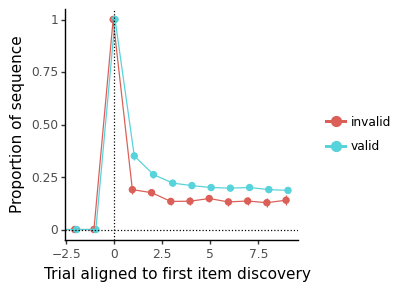

<ggplot: (168729140595)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34figures\104_repeatItemsAfterDiscoveryByExist.png


In [22]:
id_cols = ['sid', 'trial_type', 'trial_reltofirst', 'valid']
subj_dat = f_dat.loc[
      (f_dat['subtrial'] == f_dat['subtrial_sequence'])  # indicates whether the current `subtrial` (indicating the subtrial of the action, rt, etc.) is the subtrial of initial item discovery (`middle_item_both_sequence`).
    & (f_dat['trial_type'] == 'learning')
    & (f_dat['middle_item_both'] < 8)  # 4 "existing" (lead to item) and 4 "non-existing" items (random 2-key sequences), for comparable numbers
    & (f_dat['acc'] == 0)  # Only trials in which NO star was achieved, to control for that
].groupby(id_cols).aggregate('mean').reset_index()

gg.options.figure_size = (3, 3)
g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'sequence_item_bool',  # sequence_item_bool indicates whether the item that was discovered in trial 0 was executed
                                color='valid', group='valid'))
     + gg.stat_summary(position=gg.position_dodge(width=0.2))
     + gg.stat_summary(position=gg.position_dodge(width=0.2), geom='line')
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.labs(x='Trial aligned to first item discovery', y='Proportion of sequence', color='')
     + gg.coord_cartesian(xlim=(-2, 9))
#      + gg.facet_grid(' ~ middle_item_both')
    )
print(g)
g.save(os.path.join(plot_dir, '104_repeatItemsAfterDiscoveryByExist.png'))

In [23]:
id_cols = ['sid', 'trial_type', 'trial_reltofirst', 'valid']
diff_dat = pd.merge(
    subj_dat.loc[subj_dat['valid'] == 'valid', id_cols[:-1] + ['sequence_item_bool']],
    subj_dat.loc[subj_dat['valid'] == 'invalid', id_cols[:-1] + ['sequence_item_bool']],
    on=id_cols[:-1], suffixes=['_valid', '_validnot']
)
diff_dat['seq_bool_ex_minus_not'] = diff_dat['sequence_item_bool_valid'] - diff_dat['sequence_item_bool_validnot']
diff_dat = diff_dat.loc[diff_dat['trial_reltofirst'] > 0]  # Trials AFTER item discovery
diff_dat

,sid,trial_type,trial_reltofirst,sequence_item_bool_valid,sequence_item_bool_validnot,seq_bool_ex_minus_not
6,13885.0,learning,1,0.430000,0.050000,0.380000
7,13885.0,learning,2,0.306122,0.263158,0.042965
8,13885.0,learning,3,0.258065,0.181818,0.076246
9,13885.0,learning,4,0.193182,0.111111,0.082071
10,13885.0,learning,5,0.246753,0.200000,0.046753
...,...,...,...,...,...,...
835,39925.0,learning,5,0.197368,0.190476,0.006892
836,39925.0,learning,6,0.142857,0.048387,0.094470
837,39925.0,learning,7,0.207792,0.235294,-0.027502
838,39925.0,learning,8,0.174603,0.166667,0.007937


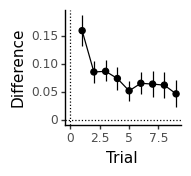

<ggplot: (168747379836)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 1.5 x 1.5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: 104_repeatItemsAfterDiscoveryDiff.png


In [24]:
gg.options.figure_size = (1.5, 1.5)
m = (gg.ggplot(diff_dat, gg.aes('trial_reltofirst', 'seq_bool_ex_minus_not'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.labs(x='Trial', y='Difference')
#      + gg.facet_grid('phase ~ trial_type')
    )
print(m)
m.save(os.path.join('104_repeatItemsAfterDiscoveryDiff.png'))

In [25]:
predictors = [
    '1',
    'trial_reltofirst + trial_type',
]

for pred in predictors:
    mod = smf.mixedlm(formula='seq_bool_ex_minus_not ~ {}'.format(pred), data=diff_dat, groups=diff_dat['sid']).fit()
    print(mod.summary())

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: seq_bool_ex_minus_not
No. Observations: 504     Method:             REML                 
No. Groups:       56      Scale:              0.0079               
Min. group size:  9       Log-Likelihood:     493.2986             
Max. group size:  9       Converged:          Yes                  
Mean group size:  9.0                                              
----------------------------------------------------------------------
              Coef.    Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------
Intercept     0.078       0.005    17.240    0.000     0.069     0.087
Group Var     0.000       0.003                                       

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: seq_bool_ex_minus_not
No. Observations: 504     Method:             REML            

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


### Split up by individual items

In [ ]:
subj_dat = f_dat.loc[
    (f_dat['subtrial'] == f_dat['subtrial_sequence']) & (f_dat['middle_item_both'] < 8)
].groupby(['sid', 'phase', 'trial_type', 'trial_reltofirst', 'middle_item_both']).aggregate('mean').reset_index()

g += gg.aes(color='factor(middle_item_both)', group='factor(middle_item_both)')
g.data = subj_dat
print(g)
g.save(os.path.join(plot_dir, '104_repeatItemsAfterDiscoveryByItem.png'))

### Differences during transfer -> modified items are practiced more (?)

In [ ]:
subj_dat = f_dat.loc[
    (f_dat['subtrial'] == f_dat['subtrial_sequence']) & (f_dat['middle_item_both'] < 4) & (f_dat['trial_type'] == 'transfer')
].groupby(['sid', 'phase', 'trial_type', 'trial_reltofirst', 'middle_item_both', 'subtrial_sequence']).aggregate('mean').reset_index()

g += gg.facet_grid('phase ~ trial_type + subtrial_sequence')
g.data = subj_dat
print(g)
g.save(os.path.join('104_repeatItemsAfterDiscoveryByItemSubtrial.png'))

## Trials it takes to transfer a sequence between positions01 and 23

In [ ]:
# Look at difference in discovery between subtrial 1 and 3 -> does it transfer?
first_dat['subtrial'] = first_dat['subtrial'].astype(int)
diff_dat = first_dat.pivot_table(
    index=['sid', 'trial_type', 'phase', 'block', 'middle_item_both'],
    columns=['subtrial'],
    values=['trial']
).reset_index()
diff_dat.columns = [''.join([str(e) for e in f]) for f in diff_dat.columns.values]
diff_dat['trial_diff_s1s3'] = np.abs(diff_dat['trial1'] - diff_dat['trial3'])
diff_dat['exists'] = diff_dat['middle_item_both'] < 4
diff_dat = diff_dat.dropna()
diff_dat

In [ ]:
subj_dat = diff_dat.loc[diff_dat['exists']].groupby(['sid', 'phase', 'trial_type', 'block', 'middle_item_both']).aggregate('mean').reset_index()

gg.options.figure_size = (5, 5)
g = (gg.ggplot(subj_dat, gg.aes('block', 'trial_diff_s1s3', color='factor(middle_item_both)'))
     + gg.stat_summary(position=gg.position_dodge(width=0.1))
     + gg.stat_summary(position=gg.position_dodge(width=0.1), geom='line')
     + gg.facet_grid('phase ~ trial_type')
    )
g

In [ ]:
subj_dat = diff_dat.groupby(['sid', 'phase', 'trial_type', 'block', 'exists']).aggregate('mean').reset_index()

gg.options.figure_size = (3, 4)
g = (gg.ggplot(subj_dat, gg.aes('1', 'trial_diff_s1s3', fill='exists'))
     + gg.stat_summary(position=gg.position_dodge(width=0.9), geom='bar')
     + gg.stat_summary(position=gg.position_dodge(width=0.9))
     + gg.scale_x_continuous(breaks=[])
     + gg.labs(x='', y='Trials to transfer sequence between positions', fill='Item appeared')
     + gg.facet_grid('phase ~ trial_type')
    )
print(g)
g.save(os.path.join('104_trialsToTransferByExists.png'))

In [ ]:
subj_dat.groupby('exists').aggregate('mean').reset_index()[['exists', 'trial_diff_s1s3']]

In [ ]:
id_cols = ['sid', 'phase', 'trial_type', 'block']
diffdiff_dat = pd.merge(
    subj_dat.loc[subj_dat['exists'], id_cols + ['trial_diff_s1s3']],
    subj_dat.loc[np.invert(subj_dat['exists']), id_cols + ['trial_diff_s1s3']],
    on=id_cols, suffixes=['_exists', '_existsnot']
)
diffdiff_dat['trial_diff_s1s3_exists_minus_not'] = diffdiff_dat['trial_diff_s1s3_exists'] - diffdiff_dat['trial_diff_s1s3_existsnot']
diffdiff_dat

In [ ]:
g = (gg.ggplot(diffdiff_dat, gg.aes('block', 'trial_diff_s1s3_exists_minus_not'))
     + gg.stat_summary()
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.facet_grid('phase ~ trial_type')
    )
g

In [ ]:
mod = smf.mixedlm(
    formula='trial_diff_s1s3_exists_minus_not ~ block',
    data=diffdiff_dat, groups=diffdiff_dat['sid']
).fit()
mod.summary()

In [ ]:
# Gradual decrease in the number of trials needed to activate middle_items
# In low transfer, 2 & 3 take much longer than 0 & 1 -> because they are new!
# In high transfer, previous knowledge is retained :)
g = (gg.ggplot(first_dat, gg.aes('block', 'trial', color='factor(middle_item_both)'))
     + gg.stat_summary(position=gg.position_dodge(width=0.5))
     + gg.stat_summary(position=gg.position_dodge(width=0.5), geom='line')
     + gg.labs(y='Trial of first activation in block')
     + gg.facet_grid('phase ~ trial_type')
    )
print(g)
g.save(os.path.join('104_trialOfSequenceDiscoveryOverBlock.png'))

## Change in RT patterns with practice

In [26]:
cols = ['sid', 'phase', 'trial_type', 'block', 'middle_item_both', 'subtrial', 'trial', 'rt']

# sub_dat1 = all_data.loc[(all_data['subtrial'] == 1), cols]
# sub_dat3 = all_data.loc[(all_data['subtrial'] == 3), cols]

sub_dat1 = all_data.loc[(all_data['middle_item_both'] < 8) & (all_data['subtrial'] == 1), cols]
sub_dat3 = all_data.loc[(all_data['middle_item_both'] < 8) & (all_data['subtrial'] == 3), cols]

sub_dat1['middle_item_both'] = sub_dat1['middle_item_both'].astype(int)
sub_dat3['middle_item_both'] = sub_dat3['middle_item_both'].astype(int)

sub_dat3[:30]

,sid,phase,trial_type,block,middle_item_both,subtrial,trial,rt
7,13885,high,learning,0.0,5,3,1.0,298.555
11,13885,high,learning,0.0,2,3,2.0,284.535
23,13885,high,learning,0.0,1,3,5.0,278.135
27,13885,high,learning,0.0,5,3,6.0,177.645
31,13885,high,learning,0.0,2,3,7.0,222.950
39,13885,high,learning,0.0,1,3,9.0,208.725
43,13885,high,learning,0.0,2,3,10.0,234.805
47,13885,high,learning,0.0,7,3,11.0,207.480
51,13885,high,learning,0.0,5,3,12.0,216.970
55,13885,high,learning,0.0,0,3,13.0,351.735


In [27]:
id_cols = ['sid', 'phase', 'trial_type', 'block', 'trial']

d1 = sub_dat1.pivot_table(index=id_cols, columns='middle_item_both', values='rt').reset_index()
d1.columns = ['rt{}'.format(c) if type(c) == int else c for c in d1.columns]

d3 = sub_dat3.pivot_table(index=id_cols, columns='middle_item_both', values='rt').reset_index()
d3.columns = ['rt{}'.format(c) if type(c) == int else c for c in d3.columns]

d3

,sid,phase,trial_type,block,trial,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7
0,13885,high,learning,0.0,1.0,NaN,NaN,NaN,NaN,NaN,298.555,NaN,NaN
1,13885,high,learning,0.0,2.0,NaN,NaN,284.535,NaN,NaN,NaN,NaN,NaN
2,13885,high,learning,0.0,5.0,NaN,278.135,NaN,NaN,NaN,NaN,NaN,NaN
3,13885,high,learning,0.0,6.0,NaN,NaN,NaN,NaN,NaN,177.645,NaN,NaN
4,13885,high,learning,0.0,7.0,NaN,NaN,222.950,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44541,39925,low,transfer,7.0,11.0,400.415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44542,39925,low,transfer,7.0,12.0,193.695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44543,39925,low,transfer,7.0,17.0,159.475,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44544,39925,low,transfer,7.0,20.0,NaN,208.265,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
def get_rt_dat(d, subtrial, middle_items=range(8)):
    
    rt_dat = pd.DataFrame()

    for middle_item in middle_items:

        item_dat = d[['sid', 'phase', 'trial_type', 'block', 'trial', 'rt{}'.format(middle_item)]].dropna()

        # Count trials
        id_cols = ['sid', 'phase', 'trial_type', 'block']
        item_dat['ones'] = 1
        item_dat['times_got_item'] = item_dat[id_cols + ['ones']].groupby(id_cols).cumsum()
        item_dat = item_dat.drop(columns=['ones'])

        # Beautify
        item_dat = item_dat.rename(columns={'rt{}'.format(middle_item): 'rt'})
        item_dat['middle_item_both'] = middle_item
        item_dat['subtrial'] = subtrial

        rt_dat = rt_dat.append(item_dat)

    rt_dat['valid'] = rt_dat['middle_item_both'].apply(lambda x : 'valid' if x < 4 else 'invalid')
    
    return rt_dat

# Example use
get_rt_dat(d1, 1)

,sid,phase,trial_type,block,trial,rt,times_got_item,middle_item_both,subtrial,valid
0,13885,high,learning,0.0,0.0,654.720,1,0,1,valid
3,13885,high,learning,0.0,5.0,232.080,2,0,1,valid
4,13885,high,learning,0.0,6.0,208.600,3,0,1,valid
5,13885,high,learning,0.0,7.0,251.455,4,0,1,valid
6,13885,high,learning,0.0,8.0,442.315,5,0,1,valid
...,...,...,...,...,...,...,...,...,...,...
46928,39925,low,learning,1.0,18.0,404.475,1,7,1,invalid
46942,39925,low,learning,2.0,12.0,246.025,1,7,1,invalid
46952,39925,low,learning,2.0,23.0,204.540,2,7,1,invalid
47116,39925,low,transfer,4.0,4.0,919.870,1,7,1,invalid


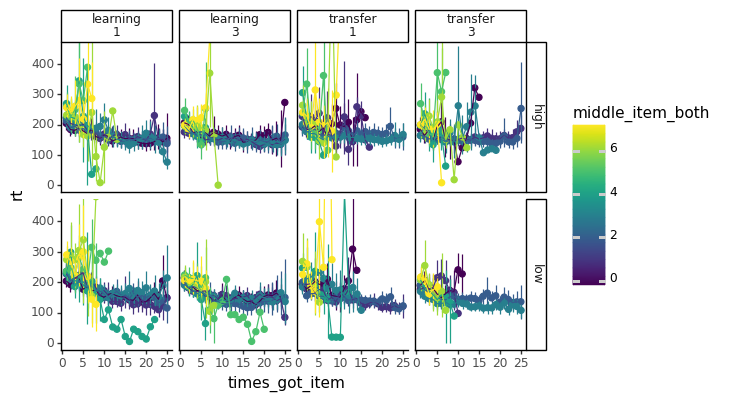

<ggplot: (168746918388)>


In [44]:
rt_dat = get_rt_dat(d1, 1).append(get_rt_dat(d3, 3))
subj_dat = rt_dat.groupby(['sid', 'phase', 'trial_type', 'times_got_item', 'middle_item_both', 'subtrial']).aggregate('mean').reset_index()

gg.options.figure_size = (6, 4)
g = (gg.ggplot(subj_dat, gg.aes('times_got_item', 'rt', color='middle_item_both', group='middle_item_both'))
     + gg.stat_summary(position=gg.position_dodge(width=0.1))
     + gg.stat_summary(position=gg.position_dodge(width=0.1), geom='line')
     + gg.facet_grid('phase ~ trial_type + subtrial', labeller='labeller_both')
     + gg.coord_cartesian(ylim=(0, 450))
    )
print(g)

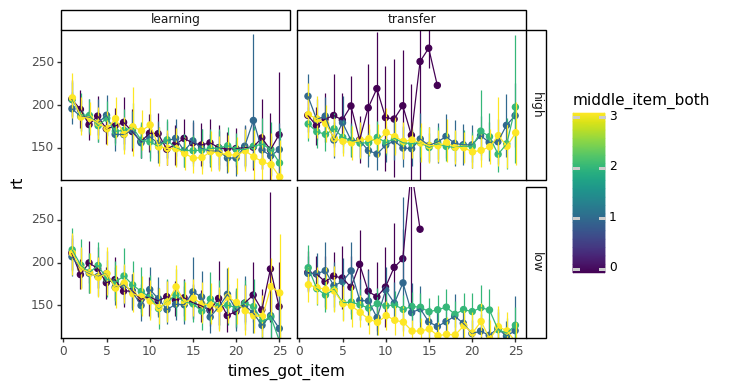

<ggplot: (168728874894)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: 104_rt2OverTimesSameSequenceExecuted.png


In [46]:
subj_dat = rt_dat.loc[rt_dat['valid'] == 'valid',
                     ].groupby(['sid', 'phase', 'trial_type', 'times_got_item', 'middle_item_both']).aggregate('mean').reset_index()

g = g + gg.facet_grid('phase ~ trial_type') + gg.coord_cartesian(ylim=(120, 280))
g.data = subj_dat
print(g)
g.save(os.path.join('104_rt2OverTimesSameSequenceExecuted.png'))

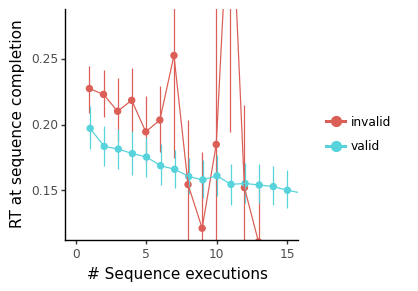

<ggplot: (168746918211)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: 104_rt2OverTimesSameSequenceExecutedByExists.png


In [75]:
subj_dat = rt_dat.groupby(['sid', 'times_got_item', 'valid']).aggregate('mean').reset_index()

gg.options.figure_size = (3, 3)
g = (gg.ggplot(subj_dat, gg.aes('times_got_item', 'rt/1000', color='valid', group='valid'))
     + gg.stat_summary(position=gg.position_dodge(width=0.1))
     + gg.stat_summary(position=gg.position_dodge(width=0.1), geom='line')
     + gg.labs(x='# Sequence executions', y='RT at sequence completion', color='')
     + gg.coord_cartesian(xlim=(0, 15), ylim=(.120, .280))
    )
print(g)
g.save(os.path.join('104_rt2OverTimesSameSequenceExecutedByExists.png'))

In [76]:
# subj_dat = rt_dat.loc[rt_dat['valid']].groupby(['sid', 'trial_type', 'times_got_item', 'subtrial', 'block']).aggregate('mean').reset_index()
subj_dat = rt_dat.loc[
    (rt_dat['trial_type'] == 'learning') & (rt_dat['times_got_item'] < 11)
].groupby(
    ['sid', 'times_got_item', 'valid']).aggregate('mean').reset_index()

mod = smf.mixedlm('rt ~ times_got_item * valid', subj_dat, groups=subj_dat['sid']).fit()
mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                    MixedLM       Dependent Variable:       rt        
No. Observations:         906           Method:                   REML      
No. Groups:               56            Scale:                    4119.2600 
Min. group size:          13            Log-Likelihood:           -5118.2096
Max. group size:          20            Converged:                Yes       
Mean group size:          16.2                                              
----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------
Intercept                      232.902   10.260 22.700 0.000 212.793 253.011
valid[T.valid]                 -30.980    9.209 -3.364 0.001 -49.030 -12.930
times_got_item                  -4.042    1.650 -2.450 0.014  -7.275  -0.809
times_got_item:valid[T.valid]   -0.309    1.901 -0.163 0.871  -4.034   3.416
Group Var                     3067.733   10.198                             
============================================================================

"""

## Increase in using valid sequences

In [ ]:
all_data['invalid'] = all_data['middle_item_both'].apply(lambda x : 1 if (x > 3) & (x < 8) else 0)
all_data['valid'] = all_data['middle_item_both'].apply(lambda x : 1 if x < 4 else 0)

id_cols = ['sid', 'phase', 'trial_type', 'trial', 'subtrial', 'block', 'acc']
dat_w = all_data.loc[
    all_data['subtrial'].isin([1, 3]),
    id_cols + ['valid', 'invalid']
].melt(id_vars=id_cols, var_name='sequence', value_name='item_achieved')
dat_w

In [ ]:
subj_dat = dat_w.loc[
    (dat_w['trial_type'] == 'learning') & (dat_w['block'] == 0) & (dat_w['acc'] == 0)
].groupby(['sid', 'trial_type', 'trial', 'sequence']).aggregate('sum').reset_index()

gg.options.figure_size = (3, 3)
g = (gg.ggplot(subj_dat, gg.aes('trial', 'item_achieved', color='sequence'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.labs(x='Trial (block 1)', y='Sequences / trial', color='')
#      + gg.facet_grid('phase ~ trial_type')
)
print(g)
g.save(os.path.join('104_sequenceFrequencyOverTrialBlock0.png'))

### Stats

In [ ]:
mod = smf.mixedlm('item_achieved ~ trial * sequence', subj_dat, groups=subj_dat['sid']).fit()
mod.summary()

In [ ]:
d = subj_dat.loc[subj_dat['sequence'] == 'valid']
mod = smf.mixedlm('item_achieved ~ trial', d, groups=d['sid']).fit()
mod.summary()

In [ ]:
d = subj_dat.loc[subj_dat['sequence'] == 'invalid']
mod = smf.mixedlm('item_achieved ~ trial', d, groups=d['sid']).fit()
mod.summary()

## Is the number of sequences per trial in incorrect trials ("hierarchical exploration") related to overall performance?

In [ ]:
all_data_sum = all_data.loc[
    (all_data['trial_type'] == 'learning') & (all_data['subtrial'] == 3)
].groupby(['sid']).aggregate('mean').reset_index()[['sid', 'acc', 'rt']]
all_data_sum

In [ ]:
sum_dat = subj_dat.groupby(['sid', 'sequence']).aggregate('mean').reset_index()[['sid', 'sequence', 'item_achieved']]
sum_dat = pd.merge(all_data_sum, sum_dat)
sum_dat

In [ ]:
g = (gg.ggplot(sum_dat, gg.aes('item_achieved', 'acc', color='sequence'))
     + gg.geom_point()
     + gg.geom_smooth(method='lm')
    )
g

In [ ]:
import scipy
for val in ['invalid', 'valid']:
    print(val)
    d = sum_dat.loc[sum_dat['sequence'] == val]
    print(scipy.stats.pearsonr(d['acc'], d['item_achieved']))

## Hm

In [ ]:
# More successful items in the first position than in the second. Because they're practicing?
all_data['bool_middle_item'] = all_data['bool_middle_item'].apply(lambda x : 0 if np.isnan(x) or x == False else 1)
subj_dat = all_data.loc[
    (all_data['acc'] == 0) & (all_data['subtrial'].isin([1, 3]))
].groupby(['sid', 'phase', 'trial_type', 'block', 'subtrial', 'bool_middle_item']).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('block', 'bool_middle_item', color='factor(subtrial)'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('phase ~ trial_type')
    )
g

# OLD AND BROKEN

## Relationship between sequence transfer (`trial_diff_s1s3`) and overall performance?

### perf_dat

In [ ]:
subj_dat = first_dat_w.groupby(['sid', 'phase', 'trial_type']).aggregate('mean').reset_index().drop(columns=['block', 'middle_item_both'])
subj_dat

In [ ]:
id_cols = ['sid', 'phase', 'trial_type']
perf_dat = all_data.groupby(id_cols).aggregate('mean').reset_index()[id_cols + ['rt', 'log_rt', 'acc']]
perf_dat = pd.merge(subj_dat, perf_dat)
perf_dat

In [ ]:
gg.options.figure_size = (8, 4)
g = (gg.ggplot(perf_dat, gg.aes('trial_diff_s1s3', 'acc', color='phase'))
     + gg.geom_point()
     + gg.geom_smooth(method='lm')
     + gg.facet_grid('~ trial_type')
    )
print(g)
g.save(os.path.join('104_accOverTrialDiffSequenceDiscorvery.png'))

In [ ]:
g += gg.aes(y='rt')
g

## Difference in learning curve between first presentation of each star

(First presentation of second star minus first presentation of first star -> is there a difference?)

In [ ]:
def get_diff_dat(all_data, blocks):
    
    t_dat = all_data.loc[(all_data['trial_type'] == 'transfer') & (all_data['block'].isin(blocks))]
    id_cols = ['sid', 'trial_type', 'phase', 'trial', 'subtrial']
    
    diff_dat = pd.merge(
        t_dat.loc[t_dat['block'] == blocks[0], id_cols + ['acc', 'rt', 'goal_star']],
        t_dat.loc[t_dat['block'] == blocks[1], id_cols + ['acc', 'rt', 'goal_star']],
        on=id_cols, suffixes=['_block{}'.format(blocks[0]), '_block{}'.format(blocks[1])]
    )
    diff_dat['acc_block{}_minus_{}'.format(blocks[1], blocks[0])] = \
        diff_dat['acc_block{}'.format(blocks[1])] - diff_dat['acc_block{}'.format(blocks[0])]
    
    return diff_dat

# # Example use
# get_diff_dat(all_data, [0, 1])

In [ ]:
blocks = [0, 1]
d = get_diff_dat(all_data, blocks)
id_cols = ['sid', 'trial_type', 'trial', 'subtrial']
dd_dat = pd.merge(d.loc[d['phase'] == 'high', id_cols + ['acc_block{}_minus_{}'.format(blocks[1], blocks[0])]],
         d.loc[d['phase'] == 'low', id_cols + ['acc_block{}_minus_{}'.format(blocks[1], blocks[0])]],
         on=id_cols, suffixes=['_high', '_low']
        )
dd_dat['{}minus{}_highminuslow'.format(blocks[1], blocks[0])] = dd_dat['acc_block1_minus_0_high'] - dd_dat['acc_block1_minus_0_low']
dd_dat

In [ ]:
g = (gg.ggplot(dd_dat, gg.aes('trial', '1minus0_highminuslow'))
     + gg.stat_summary()
     + gg.geom_hline(yintercept=0, linetype='dotted')
    )
g

In [ ]:
# Make sure we're comparing the same / different stars
d = get_diff_dat(all_data, [0, 2])
a = d.loc[np.invert(np.isnan(d['goal_star_block0'])), ['goal_star_block0', 'goal_star_block2']]
assert np.mean(a['goal_star_block0'] == a['goal_star_block2']) == 1

In [ ]:
for blocks in ([0, 1], [1, 2], [2, 3], [0, 2], [1, 3]):
    
    subj_dat = get_diff_dat(all_data, blocks).groupby(['sid', 'phase', 'trial']).aggregate('mean').reset_index()
    gg.options.figure_size = (3, 3)
    g = (gg.ggplot(subj_dat, gg.aes('trial', 'acc_block{}_minus_{}'.format(blocks[1], blocks[0]), color='phase'))
         + gg.stat_summary()
         + gg.stat_summary(geom='line')
         + gg.geom_hline(yintercept=0, linetype='dotted')
         + gg.labs(y='Acc. diff. 1st pres. each star (blocks {})'.format(blocks), color='')
        )
    print(g)

## Frequency of middle-layer item after first discovery

In [ ]:
first_dat

In [ ]:
first_dat1 = first_dat.loc[first_dat['subtrial'] == 1].reset_index()
first_dat3 = first_dat.loc[first_dat['subtrial'] == 3].reset_index()
first_dat1

In [ ]:
def make_first_dat_extra(first_dat, trial_shifts=range(-5, 10), subtrial=[]):

    first_dat_extra = pd.DataFrame()

    # Find trials around item discovery and concat into a dataframe
    for row_i in range(first_dat.shape[0]):

        if (row_i % 50) == 1:
            print('{} of {} rows ({}%)                       '.format(
                row_i+1, first_dat.shape[0], 100 * np.round((row_i+1) / first_dat.shape[0], 3)), end='\r')

        for trial_shift in trial_shifts:
            row = first_dat.loc[row_i, ['sid', 'trial_type', 'phase', 'block', 'trial', 'subtrial', 'middle_item']]
            row['trial'] += trial_shift
            if subtrial:
                row['subtrial'] = subtrial
            row['trial_reltofirst'] = trial_shift
            first_dat_extra = first_dat_extra.append(row)
            
    # Beatify dataframe
    first_dat_extra = first_dat_extra.rename(columns={'middle_item': 'middle_item_sequence', 'subtrial': 'subtrial_sequence'})
    first_dat_extra = first_dat_extra.loc[first_dat_extra['trial'] >= 0]
    first_dat_extra['trial_reltofirst'] = first_dat_extra['trial_reltofirst'].astype(int)
    first_dat_extra = first_dat_extra.reset_index(drop=True)
            
    return first_dat_extra

# # Example use
# make_first_dat_extra(first_dat3[:100], subtrial=1)

In [ ]:
first_datnot_extra = make_first_dat_extra(first_dat_not[:100].rename(columns={'middle_item1_not': 'middle_item'}))
first_datnot_extra

In [ ]:
first_dat1_extra = make_first_dat_extra(first_dat1[:100], subtrial=1)
first_dat3_extra = make_first_dat_extra(first_dat3[:100], subtrial=1)

In [ ]:
first_dat1_extra['discovery_trial'] = 1
first_dat3_extra['discovery_trial'] = 3
first_datnot_extra['discovery_trial'] = 'no sequence'

In [ ]:
first_dat13_extra = pd.concat([
    first_dat1_extra,
    first_dat3_extra,
    first_datnot_extra
]).reset_index(drop=True)
first_dat13_extra

In [ ]:
f_dat13 = pd.merge(first_dat13_extra, all_data, how='left')
f_dat13['same_item_again'] = 0

for item in range(4):
    f_dat13['bool_item_{}'.format(item)] = (f_dat13['middle_item'] == item).astype(int)
    f_dat13.loc[(f_dat13['middle_item_sequence'] == item) & (f_dat13['bool_item_{}'.format(item)] == 1), 'same_item_again'] = 1

f_dat13[['sid', 'trial_type', 'phase', 'block', 'trial', 'subtrial', 'trial_reltofirst', 'rt', 'middle_item',
       'middle_item_sequence', 'subtrial_sequence', 'bool_item_1']]

In [ ]:
f_dat13.columns

In [ ]:
subj_dat = f_dat13.loc[f_dat13['subtrial'] == 1].groupby([
    'sid', 'phase', 'trial_type', 'trial_reltofirst', 'discovery_trial'
]).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'same_item_again', color='factor(discovery_trial)'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('phase ~ trial_type')
    )
g

In [ ]:
f_dat['true_item'] = f_dat['middle_item_both'] < 4

In [ ]:
f_dat

In [ ]:
first_dat[:30]

In [ ]:
f_dat.loc[(f_dat['middle_item_both_sequence'] == 0) & (f_dat['trial_reltofirst'] <= 0) & (f_dat['bool_item_0'] == 1),
          ['sid', 'phase', 'trial_type', 'trial', 'block', 'trial_reltofirst', 'subtrial', 'middle_item_both_sequence', 'subtrial_sequence', 'action_id', 'bool_item_0']
         ][:30]

In [ ]:
subj_dat = f_dat.loc[(f_dat['middle_item_both_sequence'] == 0) & (f_dat['subtrial_sequence'] == 1)].groupby([
    'sid', 'phase', 'trial_type', 'trial_reltofirst', 'true_item', 'middle_item_both_sequence', 'block', 'subtrial_sequence',
]).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'bool_item_0', color='true_item'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('phase + subtrial_sequence ~ trial_type + middle_item_both_sequence')
    )
g

In [ ]:
subj_dat = f_dat.loc[f_dat['subtrial'] == 1].groupby([
    'sid', 'phase', 'trial_type', 'trial_reltofirst', 'true_item', 'middle_item_both_sequence', 'block', 'subtrial_sequence',
]).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'same_item_again', color='true_item'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('phase + subtrial_sequence ~ trial_type + middle_item_both_sequence')
    )
g

In [ ]:
f_dat = pd.merge(first_dat13_extra, all_data, how='left')
f_dat['same_item_again'] = 0

for item in np.unique(f_dat.loc[np.invert(np.isnan(f_dat['middle_item_both'])), 'middle_item_both']):
    f_dat['bool_item_{}'.format(item)] = (f_dat['middle_item'] == item)#.astype(int)
    f_dat.loc[(f_dat['middle_item_sequence'] == item) & (f_dat['bool_item_{}'.format(item)] == 1), 'same_item_again'] = 1

f_dat[['sid', 'trial_type', 'phase', 'block', 'trial', 'subtrial', 'trial_reltofirst', 'rt', 'middle_item',
       'middle_item_sequence', 'subtrial_sequence', 'bool_item_1.0']]

In [ ]:
f_dat['same_item_again'] = 0
f_dat.loc[(f_dat['middle_item_sequence'] == 0) & (f_dat['bool_item_0.0'] == 1), 'same_item_again'] = 1
f_dat.loc[(f_dat['middle_item_sequence'] == 1) & (f_dat['bool_item_1.0'] == 1), 'same_item_again'] = 1
f_dat.loc[(f_dat['middle_item_sequence'] == 2) & (f_dat['bool_item_2.0'] == 1), 'same_item_again'] = 1
f_dat.loc[(f_dat['middle_item_sequence'] == 3) & (f_dat['bool_item_3.0'] == 1), 'same_item_again'] = 1
f_dat

In [ ]:
np.unique(f_dat.loc[f_dat['subtrial'] == f_dat['subtrial_sequence'], ['subtrial']])

In [ ]:
np.unique(subj_dat['subtrial'])

In [ ]:
np.mean(f_dat['bool_item_3.0'])

In [ ]:
g = (gg.ggplot(f_dat, gg.aes('trial_reltofirst', 'same_item_again'))
     + gg.stat_summary()
    )
g

In [ ]:
# subj_dat = first_dat_extra.groubpy(['sid', 'phase', 'trial_type', 'trial_reltofirst']).aggregate('mean').reset_index()
subj_dat = f_dat.loc[f_dat['subtrial'] == f_dat['subtrial_sequence']
                    ].groupby(['sid', 'phase', 'trial_type', 'acc', 'trial_reltofirst', 'subtrial_sequence', 'middle_item_sequence']).aggregate('mean').reset_index()

gg.options.figure_size = (8, 6)
g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'same_item_again', color='middle_item_sequence', group='middle_item_sequence'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(-1, 9))
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.facet_grid('acc + phase ~ trial_type + subtrial_sequence', labeller='label_both')
    )
print(g)
g.save(os.path.join(plot_dir, '105_itemFrequencyOverTrialsreltofirst.png'))

In [ ]:
# same_item_again ~ star_performance + modified_item + trial_reltofirst + item_necessary_for_goal_star_at_this_position

In [ ]:
mod_dat = f_dat.loc[f_dat['trial_type'] == 'learning',
                    ['sid', 'same_item_again', 'trial_reltofirst', 'trial_type', 'subtrial_sequence', 'phase']].dropna()
mod = smf.mixedlm(
    formula='same_item_again ~ trial_reltofirst',
    data=mod_dat, groups=mod_dat['sid']
).fit()
mod.summary()

In [ ]:
mod_dat = f_dat.loc[f_dat['trial_type'] == 'transfer',
                    ['sid', 'same_item_again', 'trial_reltofirst', 'trial_type', 'subtrial_sequence', 'phase']].dropna()
mod = smf.mixedlm(
    formula='same_item_again ~ trial_reltofirst + C(subtrial_sequence) * phase',
    data=mod_dat, groups=mod_dat['sid']
).fit()
mod.summary()

In [ ]:
mod_dat = f_dat.loc[f_dat['trial_type'] == 'learning',
                    ['sid', 'same_item_again', 'trial_reltofirst', 'trial_type', 'subtrial_sequence', 'phase']].dropna()
mod = smf.mixedlm(
    formula='same_item_again ~ trial_reltofirst + C(subtrial_sequence) * phase',
    data=mod_dat, groups=mod_dat['sid']
).fit()
mod.summary()

In [ ]:
gg.options.figure_size = (5, 4)
subj_dat = f_dat.groupby(['sid', 'phase', 'trial_type', 'trial_reltofirst', 'middle_item_sequence']).aggregate('mean').reset_index()
g = g + gg.facet_grid('phase ~ trial_type')
g.data = subj_dat
g

In [ ]:
# subj_dat = first_dat_extra.groubpy(['sid', 'phase', 'trial_type', 'trial_reltofirst']).aggregate('mean').reset_index()
subj_dat = f_dat.loc[f_dat['subtrial'] == 1].groupby(['sid', 'phase', 'trial_type', 'trial_reltofirst', 'subtrial_sequence', 'middle_item_sequence']).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('trial_reltofirst', 'bool_item_0.0', color='middle_item_sequence', group='middle_item_sequence'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_vline(xintercept=0, linetype='dotted')
     + gg.facet_grid('phase + subtrial_sequence ~ trial_type')
    )
print(g)
g.save(os.path.join(plot_dir, '105_itemFrequencyOverTrialsreltofirst.png'))

In [ ]:
g += gg.aes(y='bool_item_1.0')
g

In [ ]:
g += gg.aes(y='bool_item_2.0')
g

In [ ]:
g += gg.aes(y='bool_item_3.0')
g